In [23]:
#auto reload modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import os.path as osp
import random
from typing import Dict,List

import gym.spaces as spaces
import hydra
import numpy as np
import torch
from hydra.utils import instantiate as hydra_instantiate
from omegaconf import DictConfig
from rl_utils.envs import create_vectorized_envs
from rl_utils.logging import Logger
from tensordict.tensordict import TensorDict
from torchrl.envs.utils import step_mdp
from typing import Tuple
from imitation_learning.common.evaluator import Evaluator

In [25]:
from snake_env import SnakeEnv 

In [26]:
import yaml 
cfg = yaml.load(open("bc-irl-snake.yaml", 'r'), Loader=yaml.SafeLoader)
cfg = DictConfig(cfg)

In [27]:

def set_seed(seed: int) -> None:
    """
    Sets the seed for numpy, python random, and pytorch.
    """
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

In [28]:
from gymnasium import Env
class vectorized_env():
    def __init__(self, envs : List[Env]):
        self.envs = envs
        self.num_envs = len(self.envs)
        self.observation_space = self.envs[0].observation_space
        self.action_space = self.envs[0].action_space

    def reset(self):

        return torch.tensor([env.reset()[0].tolist() for env in self.envs],dtype=torch.float32)
    
    def step(self, action) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, List[Dict]]:
        steps = [env.step(action[i]) for i,env in enumerate(self.envs)]
        return_value = (torch.tensor([step[0].tolist() for step in steps],dtype=torch.float32),
                torch.tensor([step[1] for step in steps],dtype=torch.float32),
                torch.tensor([step[2] for step in steps],dtype=torch.bool),
                [step[3] for step in steps])
        return return_value
    
    def render(self, mode = "rgb_array"):
        if(self.envs[0].render_mode == "rgb_array"):
            return [env.render(mode) for env in self.envs]
        else:
            self.envs[0].render(mode)

In [29]:
set_seed(cfg.seed)

device = torch.device(cfg.device)

# Setup the environments
set_env_settings = {
    k: hydra_instantiate(v) if isinstance(v, DictConfig) else v
    for k, v in cfg.env.env_settings.items()
}
envs = vectorized_env([SnakeEnv(cfg.env.env_settings.params.config) for _ in range(cfg.num_envs)])

steps_per_update = cfg.num_steps * cfg.num_envs
print("num_steps" , cfg.num_steps)
num_updates = int(cfg.num_env_steps) // steps_per_update

# Set dynamic variables in the config.
cfg.obs_shape = envs.observation_space.shape
cfg.action_dim = envs.action_space.shape[0]
cfg.action_is_discrete = isinstance(cfg.action_dim, spaces.Discrete)
cfg.total_num_updates = num_updates

logger: Logger = hydra_instantiate(cfg.logger, full_cfg=cfg)
policy = hydra_instantiate(cfg.policy)
policy = policy.to(device)
updater = hydra_instantiate(cfg.policy_updater, policy=policy, device=device)


num_steps 100
Assigning full prefix 62-3-umQn0d
400 100 16
observations
	 torch.Size([295, 202])
actions
	 torch.Size([295, 4])
terminals
	 torch.Size([295])
next_observations
	 torch.Size([295, 202])
rewards
	 torch.Size([295])
infos
	 295


In [30]:

start_update = 0
if cfg.load_checkpoint is not None:
    # Load a checkpoint for the policy/reward. Also potentially resume
    # training.
    ckpt = torch.load(cfg.load_checkpoint)
    updater.load_state_dict(ckpt["updater"], should_load_opt=cfg.resume_training)
    if cfg.load_policy:
        policy.load_state_dict(ckpt["policy"])
    if cfg.resume_training:
        start_update = ckpt["update_i"] + 1

eval_info = {"run_name": logger.run_name}


In [31]:
import warnings 
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")


Updates 0, Steps 1600, FPS -15818
Over the last 10 episodes:
    - episode.reward: 0.5635820891762349
    - episode.score: 0.0
    - episode.distance_to_goal: 0.4364179108237651
    - inferred_episode_reward: 4.370217645168305
    - value_loss: 4.662073421478271
    - action_loss: -0.005425080336863175
    - dist_entropy: 5.6787519454956055
    - irl_loss: 0.404005229473114
[tensor(0.1000), tensor(0.3000), 0.0, 0.0]
[tensor(0.1000), tensor(0.3000), 0.0, 0.1]
[tensor(0.1000), tensor(0.3000), 0.0, 0.2]
[tensor(0.1000), tensor(0.3000), 0.0, 0.3]
[tensor(0.1000), tensor(0.3000), 0.0, 0.4]
[tensor(0.1000), tensor(0.3000), 0.0, 0.5]
[tensor(0.1000), tensor(0.3000), 0.0, 0.6]
[tensor(0.1000), tensor(0.3000), 0.0, 0.7]
[tensor(0.1000), tensor(0.3000), 0.0, 0.8]
[tensor(0.1000), tensor(0.3000), 0.0, 0.9]
[tensor(0.1000), tensor(0.3000), 0.1, 0.0]
[tensor(0.1000), tensor(0.3000), 0.1, 0.1]
[tensor(0.1000), tensor(0.3000), 0.1, 0.2]
[tensor(0.1000), tensor(0.3000), 0.1, 0.3]
[tensor(0.1000), ten

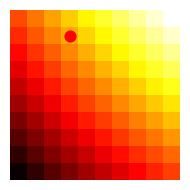

0.52 0.52 0.52 0.52 0.53 0.53 0.53 0.53 0.53 0.53 
0.52 0.52 0.52 0.52 0.53 0.53 0.53 0.53 0.53 0.53 
0.52 0.52 0.52 0.52 0.52 0.53 0.53 0.53 0.53 0.53 
0.52 0.52 0.52 0.52 0.52 0.52 0.53 0.53 0.53 0.53 
0.52 0.52 0.52 0.52 0.52 0.52 0.52 0.52 0.53 0.53 
0.52 0.52 0.52 0.52 0.52 0.52 0.52 0.52 0.52 0.53 
0.52 0.52 0.52 0.52 0.52 0.52 0.52 0.52 0.52 0.52 
0.52 0.52 0.52 0.52 0.52 0.52 0.52 0.52 0.52 0.52 
0.52 0.52 0.52 0.52 0.52 0.52 0.52 0.52 0.52 0.52 
0.52 0.52 0.52 0.52 0.52 0.52 0.52 0.52 0.52 0.52 


KeyboardInterrupt: 

In [33]:



# Storage for the rollouts
obs = envs.reset()
td = TensorDict({"observation": obs}, batch_size=[cfg.num_envs])
# Storage for the rollouts
storage_td = TensorDict({}, batch_size=[cfg.num_envs, cfg.num_steps], device=device)

for update_i in range(start_update, num_updates):
    is_last_update = update_i == num_updates - 1
    for step_idx in range(cfg.num_steps):
        # Collect experience.
        with torch.no_grad():
            policy.act(td)
        next_obs, reward, done, infos = envs.step(td["action"])

        td["next_observation"] = next_obs
        for env_i, info in enumerate(infos):
            if "final_obs" in info:
                td["next_observation"][env_i] = info["final_obs"]
        td["reward"] = reward.reshape(-1, 1)
        td["done"] = done
    
        storage_td[:, step_idx] = td

        # Log to CLI/wandb.
        logger.collect_env_step_info(infos)
    
    # Call method specific update function
    updater.update(policy, storage_td, logger, envs=envs)



    if cfg.log_interval != -1 and (
        update_i % cfg.log_interval == 0 or is_last_update
    ):
        logger.interval_log(update_i, steps_per_update * (update_i + 1))
        eval_env = SnakeEnv(cfg.env.env_settings.params.config)
        reward_map = np.zeros((eval_env.screen_width//eval_env.block_size, eval_env.screen_height//eval_env.block_size))
        apple_pos = eval_env.reset()[0][:2]
        #test what you got so far by plotting a heat map of the reward using the snake only 
        for x in range(eval_env.screen_width//eval_env.block_size):
            for y in range(eval_env.screen_height//eval_env.block_size ):
                x_grid = x * eval_env.block_size / eval_env.screen_width
                y_grid = y * eval_env.block_size / eval_env.screen_height
                print([*apple_pos,x_grid,y_grid])
                reward_map[x,y] = updater.reward(next_obs = torch.tensor([*apple_pos,x_grid,y_grid]+[0]*(eval_env.observation_space.shape[0]-3),dtype=torch.float32).to(device).view(1,1,-1))
        fig, ax = plt.subplots(figsize=(2, 2))  # Adjust the figsize as desired

        # Plot the reward map without axis and numbers
        image = ax.imshow(reward_map, cmap='hot', interpolation='nearest')
        ax.axis('off')

        # Plot the apple
        ax.scatter(
            apple_pos[1] * eval_env.screen_height // eval_env.block_size,
            apple_pos[0] * eval_env.screen_width // eval_env.block_size,
            c='red',
            s=60
        )
        plt.tight_layout()
        plt.show()
        #pretty print the reward map
        for x in range(eval_env.screen_width//eval_env.block_size):
            for y in range(eval_env.screen_height//eval_env.block_size ):
                print(f"{reward_map[x,y]:.2f}", end=" ")
            print()

    if cfg.save_interval != -1 and (
        (update_i + 1) % cfg.save_interval == 0 or is_last_update
    ):
        save_name = osp.join(logger.save_path, f"ckpt.{update_i}.pth")
        torch.save(
            {
                "policy": policy.state_dict(),
                "updater": updater.state_dict(),
                "update_i": update_i,
            },
            save_name,
        )
        print(f"Saved to {save_name}")
        eval_info["last_ckpt"] = save_name

logger.close()
print(eval_info)

In [ ]:
ckpt = torch.load(save_name)
updater.load_state_dict(ckpt["updater"], should_load_opt=cfg.resume_training)
policy.load_state_dict(ckpt["policy"])


<All keys matched successfully>

In [ ]:
import pygame

In [ ]:
cfg.env.env_settings.params.config["render_mode"] = "human"

In [ ]:

envs = vectorized_env([SnakeEnv(cfg.env.env_settings.params.config) for _ in range(1)])
while True:

    obs = envs.reset()
    td = TensorDict({"observation": obs}, batch_size=[1])
    done = False 
    while not done : 
        with torch.no_grad():
            policy.act(td)
        next_obs, reward, done, infos = envs.step(td["action"])
        envs.render(mode="human")
        td["next_observation"] = next_obs
        td["reward"] = reward.reshape(-1, 1)

        td["done"] = done

        td["observation"] = next_obs
        # Log to CLI/wandb.
        logger.collect_env_step_info(infos)
        pygame.time.wait(100)